## **IMPORTS**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteca para fazer a PADRONIZAÇÃO
from sklearn.preprocessing import StandardScaler

# Biblioteca para fazer a NORMALIZAÇÃO
from sklearn.preprocessing import MinMaxScaler

#from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Biblioteca para calcular a acuracia do modelo
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import ADASYN

from scipy.stats import tukey_hsd
from scipy import stats

## **LEITURA DOS DADOS**

In [34]:
#data = pd.read_csv('../Base de Dados/Dados_49_V.csv', na_values='?')

data = pd.read_csv('../Base de Dados/Dados_10_V_FISHER.csv', na_values='?')

print(data.shape)
data.head()

(2185, 11)


,inseminacao_2cat,total_animais_prop,teste_bruc,compra_repr,venda_repr,dest_leilao,vacina_semqqidade,piquete_parto,assist_vet,tipo_assist,resul_prop
0,0,15,0,0,0,0,0,0,0,-1,0
1,0,142,0,1,1,0,1,1,0,-1,0
2,0,40,0,1,1,0,-1,1,0,-1,0
3,0,68,0,1,0,0,1,0,0,-1,0
4,0,38,0,0,0,0,0,0,0,-1,0


In [35]:
# Gerando um DataFrame das variáveis preditoras originais SEM a variável TARGET
VAR_PREDITORAS_ORIG = data.drop('resul_prop', axis = 1)

# Gerando um DataFrame somente da variavel TARGET
VAR_TARGET = data['resul_prop']

## **NORMALIZAÇÃO**

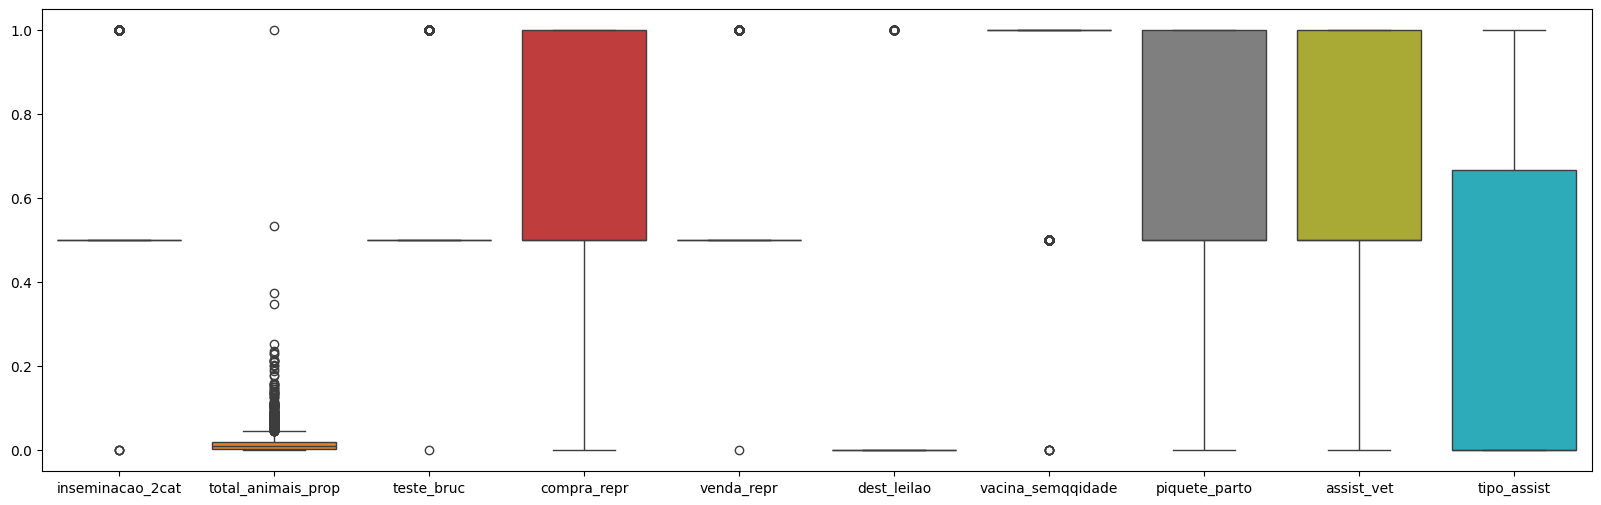

In [36]:
# Criando um objeto para NORMALIZAR os dados
obj_normalizacao = MinMaxScaler().fit(VAR_PREDITORAS_ORIG)

# Aplicando a NORMALIZAÇÃO
VAR_PREDITORAS_NORM = obj_normalizacao.transform(VAR_PREDITORAS_ORIG)

# Transformando para DataFrame e nomeando as colunas
VAR_PREDITORAS_NORM = pd.DataFrame(VAR_PREDITORAS_NORM)

VAR_PREDITORAS_NORM.columns = data.drop('resul_prop', axis = 1).columns

VAR_PREDITORAS_NORM

plt.figure(figsize=(20,6))
ax = sns.boxplot(data=VAR_PREDITORAS_NORM)

## **AGRUPAMENTO**

In [37]:
DATA_NORM = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET)
DATA_NORM_NEG = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 0').reset_index(drop=True)
DATA_NORM_POS = VAR_PREDITORAS_NORM.assign(resul_prop=VAR_TARGET).query('resul_prop == 1').reset_index(drop=True)

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(DATA_NORM_NEG.drop('resul_prop', axis = 1))
#print(kmeans.labels_)

#print(pd.DataFrame(kmeans.labels_))
DATA_NORM_NEG = DATA_NORM_NEG.assign(group=pd.DataFrame(kmeans.labels_))

DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG.query('group == 0')
#print(DATA_NORM_NEG_GROUP0.shape)

DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG.query('group == 1')
#print(DATA_NORM_NEG_GROUP1.shape)

DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG.query('group == 2')
#print(DATA_NORM_NEG_GROUP2.shape)

DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG.query('group == 3')
#print(DATA_NORM_NEG_GROUP3.shape)

DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)
DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).drop('group', axis = 1).reset_index(drop=True)

## **KNN + Replicação**

In [38]:
accuracy_rep = []

neg_prec_rep = []
neg_recall_rep = []
neg_fscore_rep = []

pos_prec_rep = []
pos_recall_rep = []
pos_fscore_rep = []

auc_rep = []

num_am_grupo_neg = 30
num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).reset_index(drop=True)
    
    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    CLASSE_NEG = pd.concat([DATA_NORM_NEG_GROUP0.head(num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.head(num_am_grupo_neg)], ignore_index = True)

    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS = pd.concat([DATA_NORM_POS.head(num_am_grupo_pos),DATA_NORM_POS.head(num_am_grupo_pos)], ignore_index = True)

    CONJ_TRAIN = pd.concat([CLASSE_NEG,CLASSE_POS]).sample(frac=1).reset_index(drop=True)

    X_TRAIN = CONJ_TRAIN.drop('resul_prop', axis = 1)
    Y_TRAIN = CONJ_TRAIN['resul_prop']


    #-------------------------- TREINANDO KNN -------------------------------
    knn = KNeighborsClassifier(n_neighbors=5).fit(X_TRAIN.values, Y_TRAIN.values)


    #-------------------------- TESTE KNN -------------------------------
    TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0.tail(len(DATA_NORM_NEG_GROUP0)-num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.tail(len(DATA_NORM_NEG_GROUP1)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.tail(len(DATA_NORM_NEG_GROUP2)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.tail(len(DATA_NORM_NEG_GROUP3)-num_am_grupo_neg)], ignore_index = True)

    #TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0[num_am_grupo_neg:(num_am_grupo_neg+6)], 
    #    DATA_NORM_NEG_GROUP1[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP2[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP3[num_am_grupo_neg:(num_am_grupo_neg+6)]], ignore_index = True)

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = knn.predict(X_TEST)


    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']
   
    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_rep.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_rep.append(report['Negativo']['precision'])
    neg_recall_rep.append(report['Negativo']['recall'])
    neg_fscore_rep.append(report['Negativo']['f1-score'])

    pos_prec_rep.append(report['Positivo']['precision'])
    pos_recall_rep.append(report['Positivo']['recall'])
    pos_fscore_rep.append(report['Positivo']['f1-score'])

    auc_rep.append(roc_auc_score(Y_TEST, knn.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

KNN_rep = pd.DataFrame().assign(KNN_accuracy_rep=accuracy_rep,
                              KNN_neg_prec_rep=neg_prec_rep,
                              KNN_neg_recall_rep=neg_recall_rep,
                              KNN_neg_fscore_rep=neg_fscore_rep,
                              KNN_pos_prec_rep=pos_prec_rep,
                              KNN_pos_recall_rep=pos_recall_rep,
                              KNN_pos_fscore_rep = pos_fscore_rep,
                              KNN_auc_rep = auc_rep)

KNN_rep.to_csv("../Resultados/KNN_"+str(data.shape[1]-1)+"V_rep.csv", encoding = 'utf-8', index = False)

print("FIM")


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  

FIM


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## **KNN + ADASYN**

In [39]:
accuracy_adasyn = []
neg_prec_adasyn = []
neg_recall_adasyn = []
neg_fscore_adasyn = []
pos_prec_adasyn = []
pos_recall_adasyn = []
pos_fscore_adasyn = []
auc_adasyn = []

num_am_grupo_neg = 60
num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).reset_index(drop=True)

    #-------------------------- ADASYN -------------------------------
    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS_ADASYN = DATA_NORM_POS.head(num_am_grupo_pos)

    CLASSE_NEG_ADASYN = DATA_NORM_NEG.drop('group', axis = 1)

    X_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN.drop('resul_prop', axis = 1),
        CLASSE_POS_ADASYN.drop('resul_prop', axis = 1)]).reset_index(drop=True)

    Y_ADASYN_ORIGINAL = pd.concat([CLASSE_NEG_ADASYN['resul_prop'],
        CLASSE_POS_ADASYN['resul_prop']]).reset_index(drop=True)

    ada = ADASYN(sampling_strategy=0.12, n_neighbors=6)

    X_RESAMPLING, Y_RESAMPLING = ada.fit_resample(X_ADASYN_ORIGINAL, Y_ADASYN_ORIGINAL)


    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    CLASSE_NEG = pd.concat([DATA_NORM_NEG_GROUP0.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP1.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.head(num_am_grupo_neg)], ignore_index = True)

    CLASSE_POS = X_RESAMPLING.assign(resul_prop=Y_RESAMPLING).query('resul_prop == 1').reset_index(drop=True)

    CONJ_TRAIN = pd.concat([CLASSE_NEG,CLASSE_POS]).sample(frac=1).reset_index(drop=True)

    X_TRAIN = CONJ_TRAIN.drop('resul_prop', axis = 1)
    Y_TRAIN = CONJ_TRAIN['resul_prop']


    #-------------------------- TREINANDO KNN -------------------------------
    knn = KNeighborsClassifier(n_neighbors=5).fit(X_TRAIN.values, Y_TRAIN.values)
    
    #-------------------------- TESTE KNN -------------------------------
    TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0.tail(len(DATA_NORM_NEG_GROUP0)-num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.tail(len(DATA_NORM_NEG_GROUP1)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.tail(len(DATA_NORM_NEG_GROUP2)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.tail(len(DATA_NORM_NEG_GROUP3)-num_am_grupo_neg)], ignore_index = True)

    #TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0[num_am_grupo_neg:(num_am_grupo_neg+6)], 
    #    DATA_NORM_NEG_GROUP1[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP2[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP3[num_am_grupo_neg:(num_am_grupo_neg+6)]], ignore_index = True)


    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = knn.predict(X_TEST)

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']

    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_adasyn.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_adasyn.append(report['Negativo']['precision'])
    neg_recall_adasyn.append(report['Negativo']['recall'])
    neg_fscore_adasyn.append(report['Negativo']['f1-score'])

    pos_prec_adasyn.append(report['Positivo']['precision'])
    pos_recall_adasyn.append(report['Positivo']['recall'])
    pos_fscore_adasyn.append(report['Positivo']['f1-score'])

    auc_adasyn.append(roc_auc_score(Y_TEST, knn.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

KNN_adasyn = pd.DataFrame().assign(KNN_accuracy_adasyn=accuracy_adasyn,
                              KNN_neg_prec_adasyn=neg_prec_adasyn,
                              KNN_neg_recall_adasyn=neg_recall_adasyn,
                              KNN_neg_fscore_adasyn=neg_fscore_adasyn,
                              KNN_pos_prec_adasyn=pos_prec_adasyn,
                              KNN_pos_recall_adasyn=pos_recall_adasyn,
                              KNN_pos_fscore_adasyn = pos_fscore_adasyn,
                              KNN_auc_adasyn = auc_adasyn)

KNN_adasyn.to_csv("../Resultados/KNN_"+str(data.shape[1]-1)+"V_adasyn.csv", encoding = 'utf-8', index = False)

print("FIM")

c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  

FIM


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## **KNN CONTROLE**

In [40]:
accuracy_contr = []

neg_prec_contr = []
neg_recall_contr = []
neg_fscore_contr = []

pos_prec_contr = []
pos_recall_contr = []
pos_fscore_contr = []

auc_contr = []

num_am_grupo_neg = 15
num_am_grupo_pos = 60

for i in range (0,100):
    DATA_NORM_NEG_GROUP0 = DATA_NORM_NEG_GROUP0.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP1 = DATA_NORM_NEG_GROUP1.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP2 = DATA_NORM_NEG_GROUP2.sample(frac=1).reset_index(drop=True)
    DATA_NORM_NEG_GROUP3 = DATA_NORM_NEG_GROUP3.sample(frac=1).reset_index(drop=True)

    #-------------------------- MONTANDO CONJUNTO DE TREINO -------------------------------
    CLASSE_NEG = pd.concat([DATA_NORM_NEG_GROUP0.head(num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.head(num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.head(num_am_grupo_neg)], ignore_index = True)

    DATA_NORM_POS = DATA_NORM_POS.sample(frac=1).reset_index(drop=True)
    CLASSE_POS = DATA_NORM_POS.head(num_am_grupo_pos)

    CONJ_TRAIN = pd.concat([CLASSE_NEG,CLASSE_POS]).sample(frac=1).reset_index(drop=True)

    X_TRAIN = CONJ_TRAIN.drop('resul_prop', axis = 1)
    Y_TRAIN = CONJ_TRAIN['resul_prop']


    #-------------------------- TREINANDO KNN -------------------------------
    knn = KNeighborsClassifier(n_neighbors=5).fit(X_TRAIN.values, Y_TRAIN.values)


    #-------------------------- TESTE KNN -------------------------------
    TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0.tail(len(DATA_NORM_NEG_GROUP0)-num_am_grupo_neg), 
        DATA_NORM_NEG_GROUP1.tail(len(DATA_NORM_NEG_GROUP1)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP2.tail(len(DATA_NORM_NEG_GROUP2)-num_am_grupo_neg),
        DATA_NORM_NEG_GROUP3.tail(len(DATA_NORM_NEG_GROUP3)-num_am_grupo_neg)], ignore_index = True)

    #TEST_NEG = pd.concat([DATA_NORM_NEG_GROUP0[num_am_grupo_neg:(num_am_grupo_neg+6)], 
    #    DATA_NORM_NEG_GROUP1[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP2[num_am_grupo_neg:(num_am_grupo_neg+6)],
    #    DATA_NORM_NEG_GROUP3[num_am_grupo_neg:(num_am_grupo_neg+6)]], ignore_index = True)

    TEST_POS = DATA_NORM_POS.tail(len(DATA_NORM_POS)-num_am_grupo_pos)

    X_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True).drop('resul_prop', axis = 1)
    Y_TEST = pd.concat([TEST_NEG,TEST_POS], ignore_index = True)['resul_prop']

    valores_preditos = knn.predict(X_TEST)

    #-------------------------- MÉTRICAS DE DESEMPENHO -------------------------------
    class_names = ['Negativo', 'Positivo']

    report = pd.DataFrame.from_dict(classification_report(Y_TEST, valores_preditos, target_names=class_names, output_dict=True))

    #ConfusionMatrixDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show(3,5)

    accuracy_contr.append(accuracy_score(Y_TEST, valores_preditos))

    neg_prec_contr.append(report['Negativo']['precision'])
    neg_recall_contr.append(report['Negativo']['recall'])
    neg_fscore_contr.append(report['Negativo']['f1-score'])

    pos_prec_contr.append(report['Positivo']['precision'])
    pos_recall_contr.append(report['Positivo']['recall'])
    pos_fscore_contr.append(report['Positivo']['f1-score'])

    auc_contr.append(roc_auc_score(Y_TEST, knn.predict_proba(X_TEST)[:, 1]))

    #RocCurveDisplay.from_estimator(rna, X_TEST, Y_TEST)
    #plt.show()

KNN_contr = pd.DataFrame().assign(KNN_accuracy_contr=accuracy_contr,
                              KNN_neg_prec_contr=neg_prec_contr,
                              KNN_neg_recall_contr=neg_recall_contr,
                              KNN_neg_fscore_contr=neg_fscore_contr,
                              KNN_pos_prec_contr=pos_prec_contr,
                              KNN_pos_recall_contr=pos_recall_contr,
                              KNN_pos_fscore_contr = pos_fscore_contr,
                              KNN_auc_contr = auc_contr)

KNN_contr.to_csv("../Resultados/KNN_"+str(data.shape[1]-1)+"V_contr.csv", encoding = 'utf-8', index = False)

print("FIM")

c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  

FIM


c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\caiod\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  

## **ESTATÍSTICA**

### **AUC**

12.663475553408453
3.771667455650584e-06


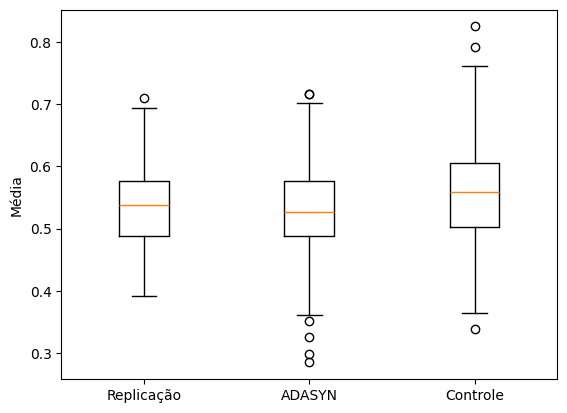

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.006     0.572    -0.008     0.020
 (0 - 2)     -0.023     0.001    -0.037    -0.009
 (1 - 0)     -0.006     0.572    -0.020     0.008
 (1 - 2)     -0.029     0.000    -0.043    -0.015
 (2 - 0)      0.023     0.001     0.009     0.037
 (2 - 1)      0.029     0.000     0.015     0.043



In [18]:
f_value, p_value = stats.f_oneway(auc_rep, auc_adasyn, auc_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([auc_rep, auc_adasyn, auc_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(auc_rep, auc_adasyn, auc_contr)
print(res)

### **ACCURACY**

19.746741436099374
4.050662869780648e-09


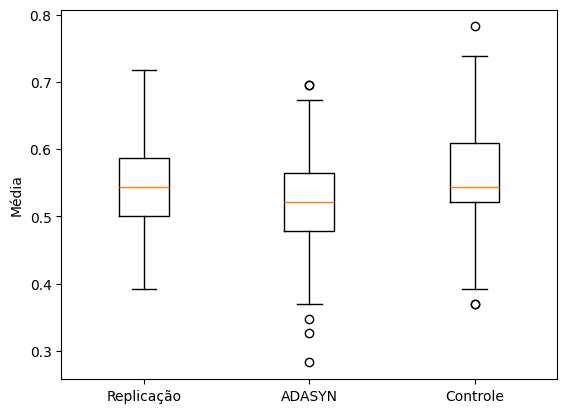

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.024     0.000     0.011     0.037
 (0 - 2)     -0.010     0.179    -0.023     0.003
 (1 - 0)     -0.024     0.000    -0.037    -0.011
 (1 - 2)     -0.034     0.000    -0.047    -0.021
 (2 - 0)      0.010     0.179    -0.003     0.023
 (2 - 1)      0.034     0.000     0.021     0.047



In [19]:
f_value, p_value = stats.f_oneway(accuracy_rep, accuracy_adasyn, accuracy_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([accuracy_rep, accuracy_adasyn, accuracy_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(accuracy_rep, accuracy_adasyn, accuracy_contr)
print(res)

### **NEGATIVO PRECISION**

2.632282782608311
0.07246958416846155


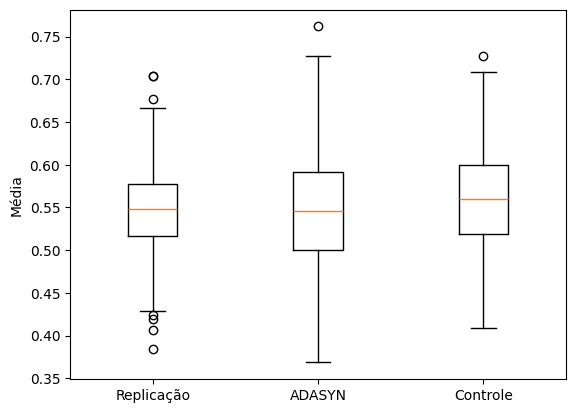

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.002     0.938    -0.013     0.010
 (0 - 2)     -0.010     0.083    -0.022     0.001
 (1 - 0)      0.002     0.938    -0.010     0.013
 (1 - 2)     -0.009     0.172    -0.020     0.003
 (2 - 0)      0.010     0.083    -0.001     0.022
 (2 - 1)      0.009     0.172    -0.003     0.020



In [11]:
f_value, p_value = stats.f_oneway(neg_prec_rep, neg_prec_adasyn, neg_prec_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_prec_rep, neg_prec_adasyn, neg_prec_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_prec_rep, neg_prec_adasyn, neg_prec_contr)
print(res)

### **POSITIVO PRECISION**

9.11298776849567
0.00012076784090892659


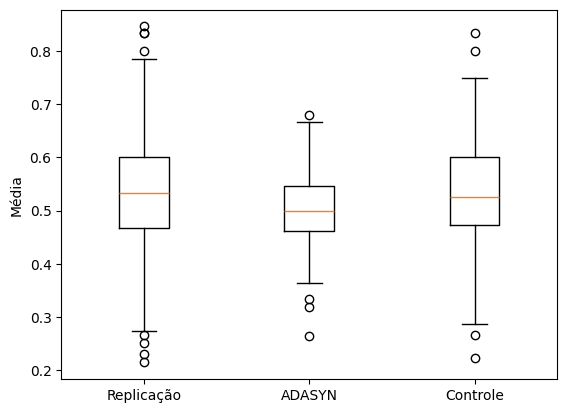

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.027     0.001     0.009     0.045
 (0 - 2)     -0.002     0.966    -0.020     0.016
 (1 - 0)     -0.027     0.001    -0.045    -0.009
 (1 - 2)     -0.029     0.000    -0.046    -0.011
 (2 - 0)      0.002     0.966    -0.016     0.020
 (2 - 1)      0.029     0.000     0.011     0.046



In [12]:
f_value, p_value = stats.f_oneway(pos_prec_rep, pos_prec_adasyn, pos_prec_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_prec_rep, pos_prec_adasyn, pos_prec_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_prec_rep, pos_prec_adasyn, pos_prec_contr)
print(res)

### **NEGATIVO RECALL**

288.7291705043921
1.56939220425655e-97


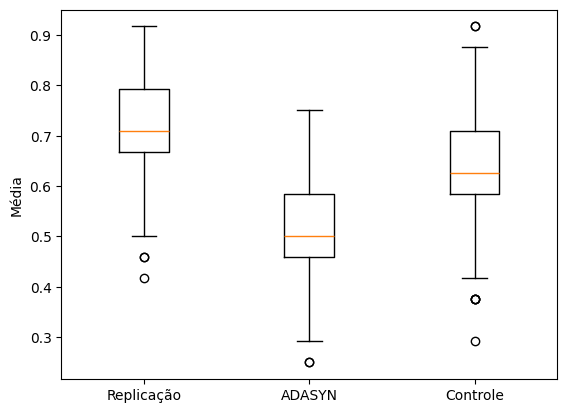

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.197     0.000     0.178     0.216
 (0 - 2)      0.075     0.000     0.056     0.095
 (1 - 0)     -0.197     0.000    -0.216    -0.178
 (1 - 2)     -0.122     0.000    -0.141    -0.102
 (2 - 0)     -0.075     0.000    -0.095    -0.056
 (2 - 1)      0.122     0.000     0.102     0.141



In [13]:
f_value, p_value = stats.f_oneway(neg_recall_rep, neg_recall_adasyn, neg_recall_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_recall_rep, neg_recall_adasyn, neg_recall_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_recall_rep, neg_recall_adasyn, neg_recall_contr)
print(res)

### **POSITIVO RECALL**

239.99338879152924
3.291613708817397e-84


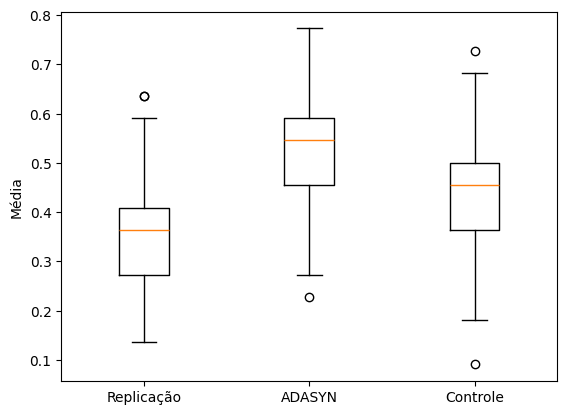

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.183     0.000    -0.202    -0.163
 (0 - 2)     -0.093     0.000    -0.113    -0.073
 (1 - 0)      0.183     0.000     0.163     0.202
 (1 - 2)      0.090     0.000     0.070     0.109
 (2 - 0)      0.093     0.000     0.073     0.113
 (2 - 1)     -0.090     0.000    -0.109    -0.070



In [14]:
f_value, p_value = stats.f_oneway(pos_recall_rep, pos_recall_adasyn, pos_recall_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_recall_rep, pos_recall_adasyn, pos_recall_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_recall_rep, pos_recall_adasyn, pos_recall_contr)
print(res)

### **NEGATIVO F1-SCORE**

123.99691022916465
2.8457789556088805e-48


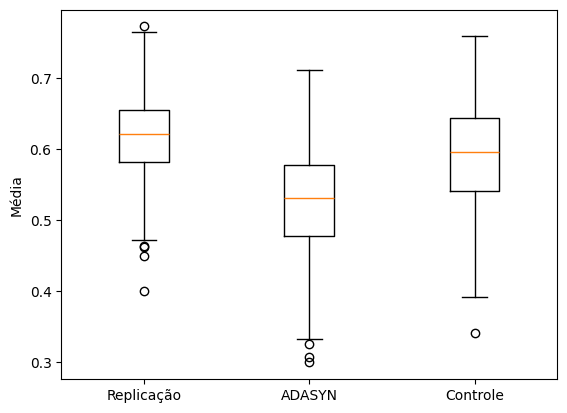

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)      0.089     0.000     0.076     0.103
 (0 - 2)      0.026     0.000     0.012     0.039
 (1 - 0)     -0.089     0.000    -0.103    -0.076
 (1 - 2)     -0.064     0.000    -0.077    -0.050
 (2 - 0)     -0.026     0.000    -0.039    -0.012
 (2 - 1)      0.064     0.000     0.050     0.077



In [15]:
f_value, p_value = stats.f_oneway(neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(neg_fscore_rep, neg_fscore_adasyn, neg_fscore_contr)
print(res)

### **POSITIVO F1-SCORE**

90.53440003349036
1.5327296244535634e-36


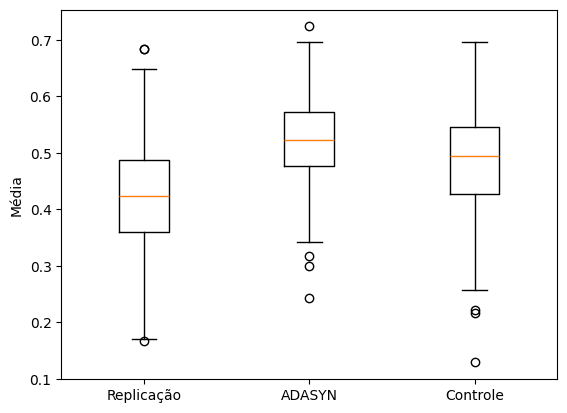

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.096     0.000    -0.113    -0.079
 (0 - 2)     -0.061     0.000    -0.078    -0.044
 (1 - 0)      0.096     0.000     0.079     0.113
 (1 - 2)      0.035     0.000     0.018     0.052
 (2 - 0)      0.061     0.000     0.044     0.078
 (2 - 1)     -0.035     0.000    -0.052    -0.018



In [16]:
f_value, p_value = stats.f_oneway(pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr)

print(f_value)
print(p_value)

fig, ax = plt.subplots(1, 1)
ax.boxplot([pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr])
ax.set_xticklabels(["Replicação", "ADASYN", "Controle"])
ax.set_ylabel("Média")
plt.show()

res = stats.tukey_hsd(pos_fscore_rep, pos_fscore_adasyn, pos_fscore_contr)
print(res)